=== 🌍 LAND COVER - ALGÉRIE (Shapefile) ===
✅ Shapefile chargé : 386454 entités
📐 CRS : EPSG:4326
📋 Colonnes : ['ID', 'GRIDCODE', 'AREA', 'LCCCODE', 'geometry']

--- Aperçu des données ---
   ID  GRIDCODE          AREA       LCCCODE  \
0   4       210  6.228187e+06  7001 // 8001   
1   2       210  6.242408e+06  7001 // 8001   
2   1       210  1.482995e+06  7001 // 8001   
3   8        50  4.590841e+08  21497-121340   
4  13       210  6.371533e+06  7001 // 8001   

                                            geometry  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...  
2  POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7...  
3  POLYGON ((6.12361 36.68472, 6.12361 36.69306, ...  
4  POLYGON ((6.26181 37.02361, 6.26193 37.02514, ...  

--- Types de données ---
ID             int32
GRIDCODE       int32
AREA         float64
LCCCODE       object
geometry    geometry
dtype: object

=== 📊 ÉVALUATION DE LA QUALITÉ DES DONNÉES ===

1️⃣ C

C:\Users\pc\AppData\Local\Temp\ipykernel_15772\3455464010.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_classes, y=col, x="Proportion (%)", palette="viridis")


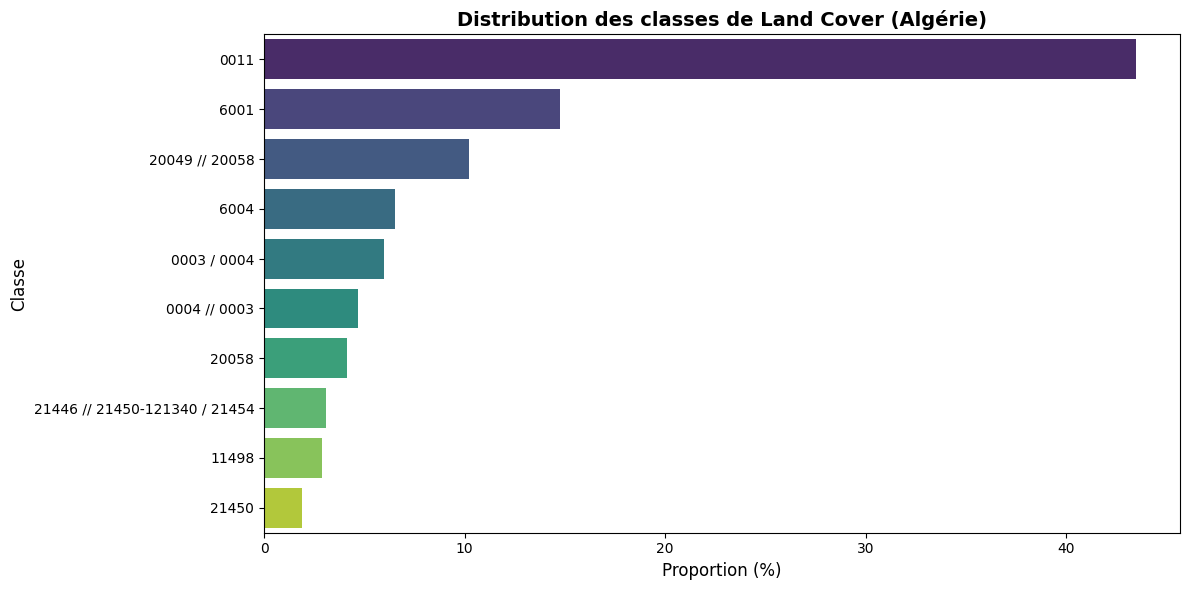

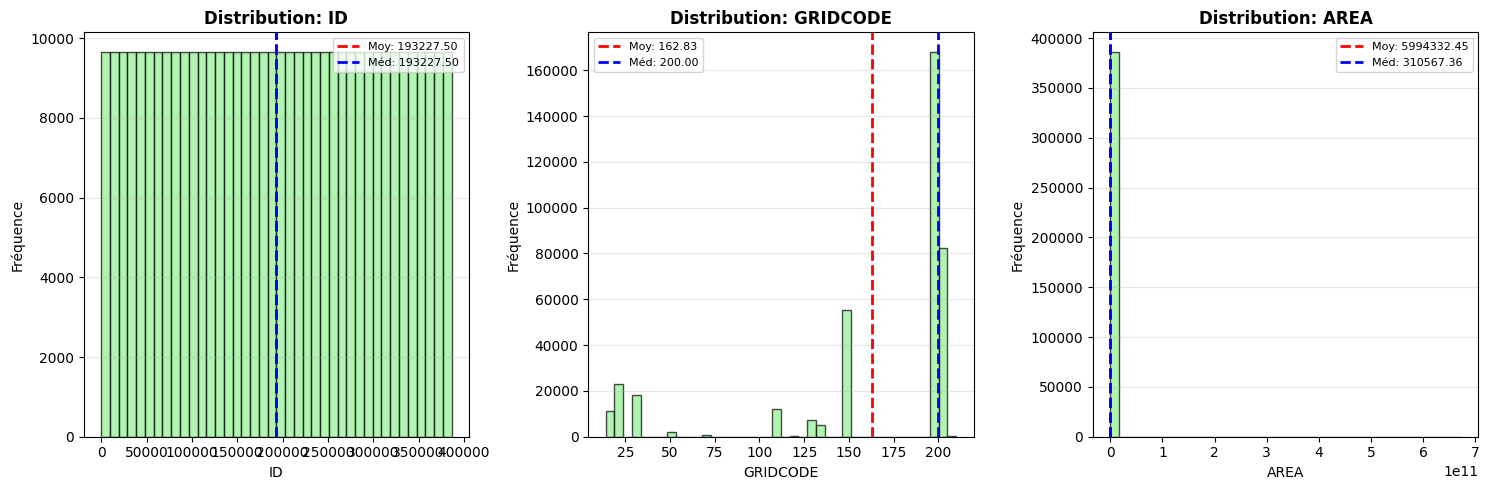

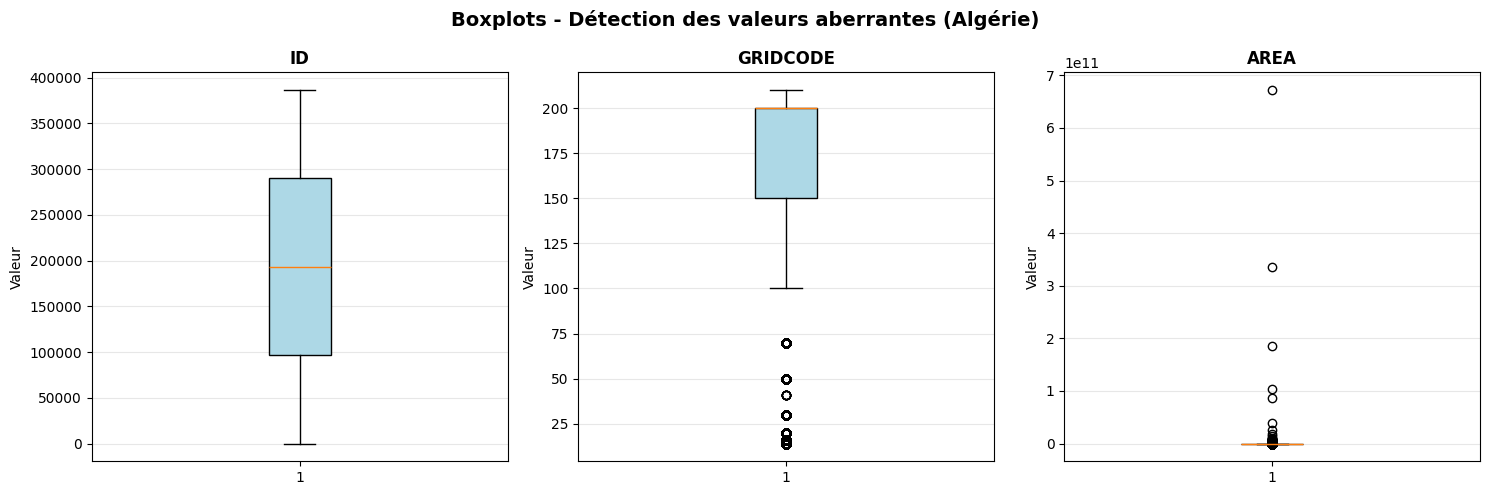


🗺️ Génération de la carte géographique...


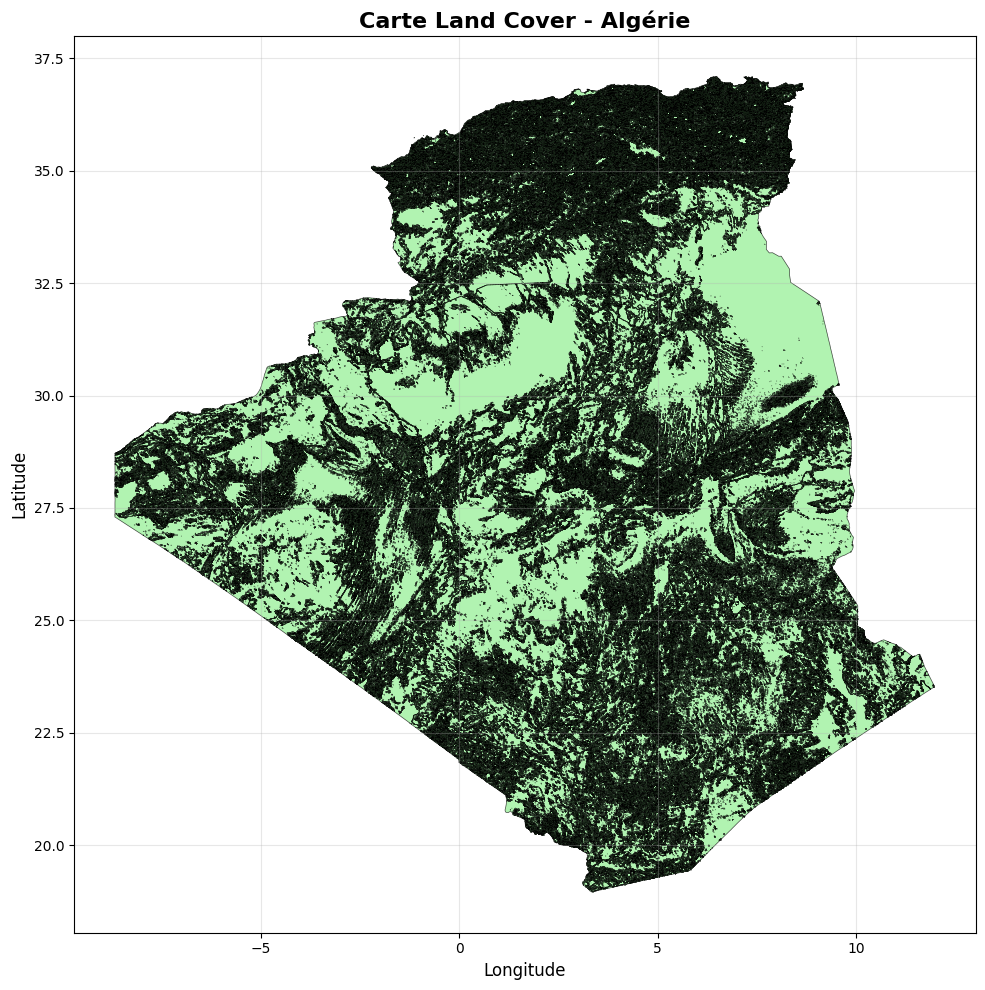


✅ Sauvegarde des données pour preprocessing...
📊 Colonnes catégorielles identifiées : ['LCCCODE']
📊 Colonnes numériques identifiées : ['ID', 'GRIDCODE', 'AREA']
📊 Outliers détectés : voir outliers_df ci-dessus

✅ PART 1 TERMINÉE - Passez à Part 2 pour le preprocessing


In [ ]:
# ========== PART 1: DATA LOADING & EDA - ALGÉRIE ==========
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats

# Chemins
landcover_path = r"C:\Users\pc\Desktop\DM\datasets\landcover"
algeria_landcover_path = os.path.join(landcover_path, "dza_gc_adg.shp")

# Chargement des données
print("="*70)
print("=== 🌍 LAND COVER - ALGÉRIE (Shapefile) ===")
print("="*70)

algeria_landcover = gpd.read_file(algeria_landcover_path)
print(f"✅ Shapefile chargé : {len(algeria_landcover)} entités")
print(f"🔍 CRS : {algeria_landcover.crs}")
print(f"📋 Colonnes : {algeria_landcover.columns.tolist()}")

print("\n--- Aperçu des données ---")
print(algeria_landcover.head())

print("\n--- Types de données ---")
print(algeria_landcover.dtypes)

# ========== DATA QUALITY ASSESSMENT ==========
print("\n" + "="*70)
print("=== 📊 ÉVALUATION DE LA QUALITÉ DES DONNÉES ===")
print("="*70)

# 1. COMPLETENESS - Valeurs manquantes
print("\n1️⃣ COMPLÉTUDE (Completeness):")
missing = (algeria_landcover.isna().sum() / len(algeria_landcover)) * 100
missing_df = pd.DataFrame({
    'Colonne': missing.index,
    'Valeurs manquantes (%)': missing.values
}).sort_values('Valeurs manquantes (%)', ascending=False)

if missing_df['Valeurs manquantes (%)'].sum() == 0:
    print("✅ Aucune valeur manquante détectée - Complétude: 100%")
else:
    print(missing_df[missing_df['Valeurs manquantes (%)'] > 0])

# 2. CONSISTENCY - Doublons
print("\n2️⃣ COHÉRENCE (Consistency):")
# Exclure la colonne geometry pour la détection des doublons
cols_for_duplicates = [col for col in algeria_landcover.columns if col != 'geometry']
duplicates = algeria_landcover.duplicated(subset=cols_for_duplicates).sum()
print(f"📋 Nombre de doublons détectés (hors geometry) : {duplicates}")
if duplicates > 0:
    print(f"⚠️ Supprimer {duplicates} doublons pour améliorer la cohérence")
    algeria_landcover = algeria_landcover.drop_duplicates(subset=cols_for_duplicates)
    print("✅ Doublons supprimés")

# Identification des colonnes
cat_cols = [col for col in algeria_landcover.select_dtypes(include='object').columns if col != 'geometry']
num_cols = algeria_landcover.select_dtypes(include=np.number).columns.tolist()

print(f"\n📊 Colonnes catégorielles : {cat_cols}")
print(f"📊 Colonnes numériques : {num_cols}")

# ========== DÉTECTION DES OUTLIERS ==========
print("\n" + "="*70)
print("=== 🔍 DÉTECTION DES VALEURS ABERRANTES (IQR Method) ===")
print("="*70)

outliers_summary = []
if len(num_cols) > 0:
    print("\n📊 Statistiques descriptives (colonnes numériques) :")
    desc = algeria_landcover[num_cols].describe().transpose()
    print(desc)
    
    for col in num_cols:
        Q1 = algeria_landcover[col].quantile(0.25)
        Q3 = algeria_landcover[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((algeria_landcover[col] < lower_bound) | (algeria_landcover[col] > upper_bound)).sum()
        outliers_pct = (outliers / len(algeria_landcover)) * 100
        outliers_summary.append({
            'Variable': col,
            'Outliers': outliers,
            'Pourcentage (%)': round(outliers_pct, 2),
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR
        })
    
    outliers_df = pd.DataFrame(outliers_summary)
    print("\n🔎 Résumé des outliers :")
    print(outliers_df)

# ========== VISUALISATIONS EDA ==========
print("\n" + "="*70)
print("=== 📈 ANALYSE EXPLORATOIRE DES DONNÉES (EDA) ===")
print("="*70)

# 1. Distribution des classes catégorielles
if len(cat_cols) > 0:
    col = cat_cols[0]
    print(f"\n📋 Répartition des classes pour '{col}' :")
    freq = algeria_landcover[col].value_counts().reset_index()
    freq.columns = [col, "Count"]
    freq["Proportion (%)"] = (freq["Count"] / freq["Count"].sum()) * 100
    print(freq.head(15))
    
    # Graphique barplot
    plt.figure(figsize=(12, 6))
    top_classes = freq.head(10)
    sns.barplot(data=top_classes, y=col, x="Proportion (%)", palette="viridis")
    plt.title(f"Distribution des classes de Land Cover (Algérie)", fontsize=14, fontweight='bold')
    plt.xlabel("Proportion (%)", fontsize=12)
    plt.ylabel("Classe", fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(landcover_path, "algeria_classes_barplot.png"), dpi=300)
    plt.show()

# 2. Histogrammes avec statistiques
if len(num_cols) > 0:
    n_cols_plot = len(num_cols)
    n_rows = (n_cols_plot + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_cols_plot > 1 else [axes]
    
    for idx, col in enumerate(num_cols):
        data = algeria_landcover[col].dropna()
        if len(data) > 0:
            axes[idx].hist(data, bins=40, edgecolor='black', color='lightgreen', alpha=0.7)
            axes[idx].set_title(f"Distribution: {col}", fontweight='bold')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel("Fréquence")
            axes[idx].grid(axis='y', alpha=0.3)
            
            mean_val = data.mean()
            median_val = data.median()
            axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Moy: {mean_val:.2f}')
            axes[idx].axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Méd: {median_val:.2f}')
            axes[idx].legend(fontsize=8)
    
    for idx in range(len(num_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(landcover_path, "algeria_histograms.png"), dpi=300)
    plt.show()

# 3. Boxplots pour outliers
if len(num_cols) > 0:
    n_box = min(len(num_cols), 5)
    fig, axes = plt.subplots(1, n_box, figsize=(15, 5))
    if n_box == 1:
        axes = [axes]
    
    for idx, col in enumerate(num_cols[:n_box]):
        data = algeria_landcover[col].dropna()
        if len(data) > 0:
            bp = axes[idx].boxplot(data, vert=True, patch_artist=True)
            for patch in bp['boxes']:
                patch.set_facecolor('lightblue')
            axes[idx].set_title(col, fontweight='bold')
            axes[idx].set_ylabel("Valeur")
            axes[idx].grid(axis='y', alpha=0.3)
    
    plt.suptitle("Boxplots - Détection des valeurs aberrantes (Algérie)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(landcover_path, "algeria_boxplots.png"), dpi=300)
    plt.show()

# 4. Carte géographique
print("\n🗺️ Génération de la carte géographique...")
fig, ax = plt.subplots(figsize=(12, 10))
algeria_landcover.plot(ax=ax, color="lightgreen", edgecolor="black", linewidth=0.5, alpha=0.7)
ax.set_title("Carte Land Cover - Algérie", fontsize=16, fontweight='bold')
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(landcover_path, "algeria_map.png"), dpi=300)
plt.show()

# Sauvegarder les données brutes pour la prochaine étape
print("\n✅ Sauvegarde des données pour preprocessing...")
print(f"📊 Colonnes catégorielles identifiées : {cat_cols}")
print(f"📊 Colonnes numériques identifiées : {num_cols}")
print(f"📊 Outliers détectés : voir outliers_df ci-dessus")
print("\n✅ PART 1 TERMINÉE - Passez à Part 2 pour le preprocessing")


In [4]:
# ========== PART 2: DATA PREPROCESSING - ALGÉRIE 
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Chemins
landcover_path = r"C:\Users\pc\Desktop\DM\datasets\landcover"
algeria_landcover_path = os.path.join(landcover_path, "dza_gc_adg.shp")

# Chargement des données
algeria_landcover = gpd.read_file(algeria_landcover_path)

# Suppression des doublons 
cols_for_duplicates = [col for col in algeria_landcover.columns if col != 'geometry']
algeria_landcover = algeria_landcover.drop_duplicates(subset=cols_for_duplicates)

print("="*70)
print("=== 🔧 DATA PREPROCESSING - ALGÉRIE (VERSION SIMPLIFIÉE) ===")
print("="*70)
print(f"📊 Shape initial : {algeria_landcover.shape}")
print(f"📊 Colonnes initiales : {algeria_landcover.columns.tolist()}")

# =====================================================================
# 1️⃣ SUPPRESSION DES COLONNES INUTILES
# =====================================================================
print("\n" + "="*70)
print("=== 🗑️ SUPPRESSION DES COLONNES INUTILES ===")
print("="*70)

cols_to_drop = ['AREA', 'ID', 'GRIDCODE']
existing_cols_to_drop = [col for col in cols_to_drop if col in algeria_landcover.columns]

print(f"📋 Colonnes à supprimer : {existing_cols_to_drop}")
algeria_processed = algeria_landcover.drop(columns=existing_cols_to_drop)
print(f"✅ Colonnes supprimées avec succès")
print(f"📊 Shape après suppression : {algeria_processed.shape}")
print(f"📊 Colonnes restantes : {algeria_processed.columns.tolist()}")

# =====================================================================
# 2️⃣ VÉRIFICATION DES COLONNES FINALES
# =====================================================================
print("\n" + "="*70)
print("=== 📋 VÉRIFICATION DES COLONNES FINALES ===")
print("="*70)

# Identifier les colonnes catégorielles (hors geometry)
cat_cols_final = [col for col in algeria_processed.select_dtypes(include='object').columns if col != 'geometry']
print(f"📊 Colonnes catégorielles restantes : {cat_cols_final}")

# Vérifier s'il reste des colonnes numériques
num_cols_final = algeria_processed.select_dtypes(include=np.number).columns.tolist()
print(f"📊 Colonnes numériques restantes : {num_cols_final if num_cols_final else 'Aucune'}")

# Geometry
print(f"📊 Colonne geometry préservée : {'geometry' in algeria_processed.columns}")

# =====================================================================
# 3️⃣ SÉLECTION DES COLONNES FINALES
# =====================================================================
print("\n" + "="*70)
print("=== 📋 SÉLECTION DES COLONNES FINALES ===")
print("="*70)

algeria_final = algeria_processed[['LCCCODE', 'geometry']].copy()
print(f"✅ Colonnes finales sélectionnées : ['LCCCODE', 'geometry']")
print(f"📊 Shape final : {algeria_final.shape}")

# =====================================================================
# 4️⃣ SAUVEGARDE DES RÉSULTATS
# =====================================================================
print("\n" + "="*70)
print("=== 💾 SAUVEGARDE DES RÉSULTATS ===")
print("="*70)

# Sauvegarder en shapefile avec LCCCODE et geometry
output_shapefile = os.path.join(landcover_path, "algeria_preprocessed.shp")
algeria_final.to_file(output_shapefile)
print(f"✅ Shapefile sauvegardé avec colonnes [LCCCODE, geometry] : {output_shapefile}")

# Sauvegarder en CSV avec LCCCODE et geometry
output_csv = os.path.join(landcover_path, "algeria_preprocessed.csv")
algeria_final.to_csv(output_csv, index=False)
print(f"✅ CSV sauvegardé avec colonnes [LCCCODE, geometry] : {output_csv}")
print(f"📊 Nombre de lignes : {len(algeria_final)}")

# =====================================================================
# 5️⃣ RÉSUMÉ FINAL
# =====================================================================
print("\n" + "="*70)
print("=== 📊 RÉSUMÉ DU PREPROCESSING ===")
print("="*70)
print(f"1️⃣ Colonnes supprimées : {existing_cols_to_drop}")
print(f"2️⃣ Colonnes finales conservées : ['LCCCODE', 'geometry']")
print(f"3️⃣ Shape final : {algeria_final.shape}")
print(f"4️⃣ Fichiers sauvegardés :")
print(f"   - Shapefile : {output_shapefile}")
print(f"   - CSV : {output_csv}")

print("\n--- Aperçu des données preprocessées ---")
print(algeria_final.head())

print("\n✅ PART 2 TERMINÉE - Shapefile et CSV créés avec LCCCODE et geometry")
print("="*70)

=== 🔧 DATA PREPROCESSING - ALGÉRIE (VERSION SIMPLIFIÉE) ===
📊 Shape initial : (386454, 5)
📊 Colonnes initiales : ['ID', 'GRIDCODE', 'AREA', 'LCCCODE', 'geometry']

=== 🗑️ SUPPRESSION DES COLONNES INUTILES ===
📋 Colonnes à supprimer : ['AREA', 'ID', 'GRIDCODE']
✅ Colonnes supprimées avec succès
📊 Shape après suppression : (386454, 2)
📊 Colonnes restantes : ['LCCCODE', 'geometry']

=== 📋 VÉRIFICATION DES COLONNES FINALES ===
📊 Colonnes catégorielles restantes : ['LCCCODE']
📊 Colonnes numériques restantes : Aucune
📊 Colonne geometry préservée : True

=== 📋 SÉLECTION DES COLONNES FINALES ===
✅ Colonnes finales sélectionnées : ['LCCCODE', 'geometry']
📊 Shape final : (386454, 2)

=== 💾 SAUVEGARDE DES RÉSULTATS ===
✅ Shapefile sauvegardé avec colonnes [LCCCODE, geometry] : C:\Users\pc\Desktop\DM\datasets\landcover\algeria_preprocessed.shp
✅ CSV sauvegardé avec colonnes [LCCCODE, geometry] : C:\Users\pc\Desktop\DM\datasets\landcover\algeria_preprocessed.csv
📊 Nombre de lignes : 386454

=== 📊 R